In [1]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import xarray as xr
import scipy

from tqdm import tqdm

import torch
from torch import nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

In [3]:
# Read data in and cut to region
#ds_moc = xr.open_dataset("../CESM_data/CESM1LE_MOC_NAtl_20N-50N_19200101_20051201.nc")

ds_sst = xr.open_dataset("../CESM_data/CESM1LE_sst_NAtl_19200101_20051201.nc")['sst'][21:54,:,:,:]
#ds_FLNS = xr.open_dataset("../CESM_data/CESM1LE_FLNS_NAtl_19200101_20051201.nc")['FLNS'][21:54,0:89,:,:]
#ds_FSNS = xr.open_dataset("../CESM_data/CESM1LE_FSNS_NAtl_19200101_20051201.nc")['FSNS'][21:54,0:89,:,:]
#ds_LHFLX = xr.open_dataset("../CESM_data/CESM1LE_LHFLX_NAtl_19200101_20051201.nc")['LHFLX'][21:54,0:89,:,:]
#ds_NHFLX = xr.open_dataset("../CESM_data/CESM1LE_NHFLX_NAtl_19200101_20051201.nc")['NHFLX'][21:54,0:89,:,:]
#ds_SHFLX = xr.open_dataset("../CESM_data/CESM1LE_SHFLX_NAtl_19200101_20051201.nc")['SHFLX'][21:54,0:89,:,:]
ds_sss = xr.open_dataset("../CESM_data/CESM1LE_sss_NAtl_19200101_20051201.nc")['sss'][21:54,0:89,:,:]
ds_psl = xr.open_dataset("../CESM_data/CESM1LE_psl_NAtl_19200101_20051201.nc")['psl'][21:54,0:89,:,:]

In [4]:
# Apply Latitude Weights (Cosine of Latitude)
lat_weighted_sst = np.cos(ds_sst.lat*np.pi/180) * ds_sst
lat_weighted_sss = np.cos(ds_sss.lat*np.pi/180) * ds_sss
lat_weighted_psl = np.cos(ds_psl.lat*np.pi/180) * ds_psl

In [5]:
ds_psl

<xarray.DataArray 'psl' (lat: 33, lon: 89, time: 1032, ensemble: 42)>
[127301328 values with dtype=float32]
Coordinates:
  * lat       (lat) float64 20.26 21.2 22.15 23.09 ... 47.59 48.53 49.48 50.42
  * lon       (lon) float64 -90.0 -88.75 -87.5 -86.25 ... 16.25 17.5 18.75 20.0
  * time      (time) object 1920-01-01 00:00:00 ... 2005-12-01 00:00:00
  * ensemble  (ensemble) int64 1 2 3 4 5 6 7 8 9 ... 34 35 36 37 38 39 40 41 42

In [6]:
def deseason(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]

    data_deseason[np.isnan(data_deseason)] = 0
    return data_deseason

In [15]:
def deseason_detrend(ds):
    data = ds.T.values
    monthly_means = np.zeros((42,86,12,89,33))
    
    iyr = 0
    for it in range(1032):
        mo_ind = it%12
        monthly_means[:,iyr,mo_ind,:,:] = data[:,it,:,:]
        if mo_ind==11:
            iyr+=1
    monthly_means = np.nanmean(monthly_means,axis=1)
    
    data_deseason = np.zeros(data.shape)
    for it in range(1032):
        mo_ind = it%12
        data_deseason[:,it,:,:] = data[:,it,:,:] - monthly_means[:,mo_ind,:,:]
    
    data_detrend = data_deseason - np.nanmean( data_deseason, axis=0 )
    data_detrend[np.isnan(data_detrend)] = 0
    return data_detrend



In [16]:
%%time
sst_deseasoned = deseason(lat_weighted_sst)
sss_deseasoned = deseason(lat_weighted_sss)
psl_deseasoned = deseason(lat_weighted_psl)

/Users/gliu/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:11: RuntimeWarning: Mean of empty slice
  # This is added back by InteractiveShellApp.init_path()


CPU times: user 12.5 s, sys: 2.73 s, total: 15.2 s
Wall time: 15.3 s


In [17]:
%%time
sst_normed = (sst_deseasoned - np.mean(sst_deseasoned))/np.std(sst_deseasoned)
sss_normed = (sss_deseasoned - np.mean(sss_deseasoned))/np.std(sss_deseasoned)
psl_normed = (psl_deseasoned - np.mean(psl_deseasoned))/np.std(psl_deseasoned)

CPU times: user 2.77 s, sys: 1.74 s, total: 4.51 s
Wall time: 4.51 s


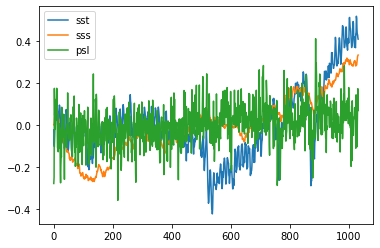

In [18]:
plt.plot(np.mean(sst_normed,axis=(0,2,3)))
plt.plot(np.mean(sss_normed,axis=(0,2,3)))
plt.plot(np.mean(psl_normed,axis=(0,2,3)))
plt.legend(['sst','sss','psl'])

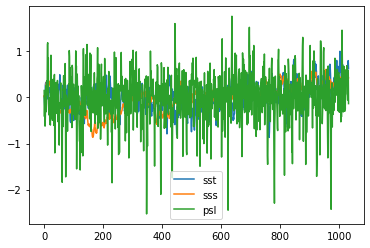

In [19]:
plt.plot(np.mean(sst_normed,axis=(2,3))[30,:])
plt.plot(np.mean(sss_normed,axis=(2,3))[30,:])
plt.plot(np.mean(psl_normed,axis=(2,3))[30,:])
plt.legend(['sst','sss','psl'])

In [20]:
sst_normed.shape

(42, 1032, 89, 33)

In [21]:
np.save("../CESM_data/CESM_SST_normalized_lat_weighted.npy",sst_normed)

In [22]:
np.save("../CESM_data/CESM_SSS_normalized_lat_weighted.npy",sss_normed)

In [23]:
np.save("../CESM_data/CESM_PSL_normalized_lat_weighted.npy",psl_normed)